In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Note: If running with the rtx 3070, run using the latest pytorch image from nvidia webpage

Previously used: `docker pull nvcr.io/nvidia/pytorch:21.03-py3`

In [2]:
#%cd /notebook/Masters_Project/ganomaly
%cd /content/drive/MyDrive/Masters_Project/Datasets/OASIS3/ganomaly_pytorch/

/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/ganomaly_pytorch


In [3]:
#!git clone https://github.com/samet-akcay/ganomaly.git

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 163kB 14.5MB/s 
     |████████████████████████████████| 440kB 14.9MB/s 
     |████████████████████████████████| 2.3MB 16.3MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 286kB 53.3MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 13.1MB 25.0MB/s 
     |████████████████████████████████| 17.3MB 193kB/s 
     |████████████████████████████████| 112kB 62.8MB/s 
     |████████████████████████████████| 163kB 57.1MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 235kB 59.9MB/s 
     |████████████████████████████████| 512kB 51.4MB/s 
     |████████████████████████████████| 1.1MB 43.9MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 6.7MB 51.0MB/s 


In [5]:
!pip install mkl-fft

     |████████████████████████████████| 245kB 7.5MB/s 
     |████████████████████████████████| 171.6MB 82kB/s 
     |████████████████████████████████| 31.6MB 190kB/s 
     |████████████████████████████████| 169.0MB 94kB/s 
     |████████████████████████████████| 3.9MB 49.7MB/s 


In [6]:
#!pip install visdom
# Run via a bash terminal on the continer: python3 -m visdom.server &

In [7]:
import os
import torch
import numpy as np
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from PIL import Image

In [8]:
from options import Options
from lib.data import load_data
from lib.model import Ganomaly

In [9]:
import torch

torch.cuda.is_available()

True

In [10]:
torch.__version__

'1.2.0'

In [11]:
class Option:
    def __init__(self):
        # Base
        self.dataset = 'cifar10'
        self.dataroot = ''
        self.batchsize = 64
        self.workers = 8
        self.droplast = True
        self.isize = 32
        self.nc = 3
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        self.extralayers = 0
        self.device = 'gpu'
        self.gpu_ids = '0'
        self.ngpu = 1
        self.name = 'pytorch_ganomaly'
        self.model = 'ganomaly'
        self.display_server = "http://localhost"
        self.display_port = 8097
        self.display_id = 0
        self.display = False
        self.outf = './pyt_ganomaly_output'
        self.manualseed = -1
        self.abnormal_class = 'car'
        self.proportion = 0.1
        self.metric = 'roc'

        ##
        # Train
        self.print_freq = 100
        self.save_image_freq = 100
        self.save_test_images = True
        self.load_weights = False
        self.resume = ''
        self.phase = 'train'
        self.iter = 0
        self.niter = 15
        self.beta1 = 0.5
        self.lr = 0.0002
        self.w_adv = 1
        self.w_con = 50
        self.w_enc = 1
        self.isTrain = True

opt = Option()

In [12]:
def get_cifar_anomaly_dataset(trn_img, trn_lbl, tst_img, tst_lbl, abn_cls_idx=0, manualseed=-1):
    """[summary]
    Arguments:
        trn_img {np.array} -- Training images
        trn_lbl {np.array} -- Training labels
        tst_img {np.array} -- Test     images
        tst_lbl {np.array} -- Test     labels
    Keyword Arguments:
        abn_cls_idx {int} -- Anomalous class index (default: {0})
    Returns:
        [np.array] -- New training-test images and labels.
    """
    # Convert train-test labels into numpy array.
    trn_lbl = np.array(trn_lbl)
    tst_lbl = np.array(tst_lbl)

    # --
    # Find idx, img, lbl for abnormal and normal on org dataset.
    nrm_trn_idx = np.where(trn_lbl != abn_cls_idx)[0]
    abn_trn_idx = np.where(trn_lbl == abn_cls_idx)[0]
    nrm_trn_img = trn_img[nrm_trn_idx]    # Normal training images
    abn_trn_img = trn_img[abn_trn_idx]    # Abnormal training images
    nrm_trn_lbl = trn_lbl[nrm_trn_idx]    # Normal training labels
    abn_trn_lbl = trn_lbl[abn_trn_idx]    # Abnormal training labels.

    nrm_tst_idx = np.where(tst_lbl != abn_cls_idx)[0]
    abn_tst_idx = np.where(tst_lbl == abn_cls_idx)[0]
    nrm_tst_img = tst_img[nrm_tst_idx]    # Normal training images
    abn_tst_img = tst_img[abn_tst_idx]    # Abnormal training images.
    nrm_tst_lbl = tst_lbl[nrm_tst_idx]    # Normal training labels
    abn_tst_lbl = tst_lbl[abn_tst_idx]    # Abnormal training labels.

    # --
    # Assign labels to normal (0) and abnormals (1)
    nrm_trn_lbl[:] = 0
    nrm_tst_lbl[:] = 0
    abn_trn_lbl[:] = 1
    abn_tst_lbl[:] = 1

    # --
    if manualseed != -1:
        # Random seed.
        # Concatenate the original train and test sets.
        nrm_img = np.concatenate((nrm_trn_img, nrm_tst_img), axis=0)
        nrm_lbl = np.concatenate((nrm_trn_lbl, nrm_tst_lbl), axis=0)
        abn_img = np.concatenate((abn_trn_img, abn_tst_img), axis=0)
        abn_lbl = np.concatenate((abn_trn_lbl, abn_tst_lbl), axis=0)

        # Split the normal data into the new train and tests.
        idx = np.arange(len(nrm_lbl))
        np.random.seed(manualseed)
        np.random.shuffle(idx)

        nrm_trn_len = int(len(idx) * 0.80)
        nrm_trn_idx = idx[:nrm_trn_len]
        nrm_tst_idx = idx[nrm_trn_len:]

        nrm_trn_img = nrm_img[nrm_trn_idx]
        nrm_trn_lbl = nrm_lbl[nrm_trn_idx]
        nrm_tst_img = nrm_img[nrm_tst_idx]
        nrm_tst_lbl = nrm_lbl[nrm_tst_idx]

    # Create new anomaly dataset based on the following data structure:
    # - anomaly dataset
    #   . -> train
    #        . -> normal
    #   . -> test
    #        . -> normal
    #        . -> abnormal
    new_trn_img = np.copy(nrm_trn_img)
    new_trn_lbl = np.copy(nrm_trn_lbl)
    new_tst_img = np.concatenate((nrm_tst_img, abn_trn_img, abn_tst_img), axis=0)
    new_tst_lbl = np.concatenate((nrm_tst_lbl, abn_trn_lbl, abn_tst_lbl), axis=0)

    return new_trn_img, new_trn_lbl, new_tst_img, new_tst_lbl


In [13]:
splits = ['train', 'test']
drop_last_batch = {'train': True, 'test': False}
shuffle = {'train': True, 'test': False}

transform = transforms.Compose(
    [
        transforms.Resize(opt.isize),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

classes = {
    'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
    'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
}

dataset = {}
dataset['train'] = CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset['test'] = CIFAR10(root='./data', train=False, download=True, transform=transform)

dataset['train'].data, dataset['train'].targets, \
dataset['test'].data, dataset['test'].targets = get_cifar_anomaly_dataset(
    trn_img=dataset['train'].data,
    trn_lbl=dataset['train'].targets,
    tst_img=dataset['test'].data,
    tst_lbl=dataset['test'].targets,
    abn_cls_idx=classes[opt.abnormal_class],
    manualseed=opt.manualseed
)

dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                             batch_size=opt.batchsize,
                                             shuffle=shuffle[x],
                                             num_workers=int(opt.workers),
                                             drop_last=drop_last_batch[x],
                                             worker_init_fn=(None if opt.manualseed == -1
                                             else lambda x: np.random.seed(opt.manualseed)))
              for x in splits}

Files already downloaded and verified
Files already downloaded and verified


In [14]:
model = Ganomaly(opt, dataloader)
model.train()

  0%|          | 0/703 [00:00<?, ?it/s]

>> Training model Ganomaly.


>> Training model Ganomaly. Epoch 1/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 4.447 roc: 0.619 max roc: 0.619


>> Training model Ganomaly. Epoch 2/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.638 roc: 0.629 max roc: 0.629


>> Training model Ganomaly. Epoch 3/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.595 roc: 0.609 max roc: 0.629


>> Training model Ganomaly. Epoch 4/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.447 roc: 0.574 max roc: 0.629


>> Training model Ganomaly. Epoch 5/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.471 roc: 0.543 max roc: 0.629


>> Training model Ganomaly. Epoch 6/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.630 roc: 0.697 max roc: 0.697


>> Training model Ganomaly. Epoch 7/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.599 roc: 0.614 max roc: 0.697


>> Training model Ganomaly. Epoch 8/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.659 roc: 0.659 max roc: 0.697


>> Training model Ganomaly. Epoch 9/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.669 roc: 0.666 max roc: 0.697


>> Training model Ganomaly. Epoch 10/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.583 roc: 0.564 max roc: 0.697


>> Training model Ganomaly. Epoch 11/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.567 roc: 0.648 max roc: 0.697


>> Training model Ganomaly. Epoch 12/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.626 roc: 0.575 max roc: 0.697


>> Training model Ganomaly. Epoch 13/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.566 roc: 0.629 max roc: 0.697


>> Training model Ganomaly. Epoch 14/15


  0%|          | 0/703 [00:00<?, ?it/s]

   Avg Run Time (ms/batch): 3.623 roc: 0.589 max roc: 0.697


>> Training model Ganomaly. Epoch 15/15


   Avg Run Time (ms/batch): 3.873 roc: 0.612 max roc: 0.697
>> Training model Ganomaly.[Done]


In [15]:
model.test()

OrderedDict([('Avg Run Time (ms/batch)', 4.206349849700928),
             ('roc', 0.6117080555555556)])

In [16]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'an_scores',
 'backward_d',
 'backward_g',
 'dataloader',
 'device',
 'epoch',
 'err_d',
 'err_d_fake',
 'err_d_real',
 'err_g',
 'err_g_adv',
 'err_g_con',
 'err_g_enc',
 'fake',
 'fake_label',
 'feat_fake',
 'feat_real',
 'fixed_input',
 'forward_d',
 'forward_g',
 'get_current_images',
 'get_errors',
 'gt',
 'gt_labels',
 'input',
 'l_adv',
 'l_bce',
 'l_con',
 'l_enc',
 'label',
 'latent_i',
 'latent_o',
 'name',
 'netd',
 'netg',
 'opt',
 'optimize_params',
 'optimizer_d',
 'optimizer_g',
 'pred_fake',
 'pred_real',
 'real_label',
 'reinit_d',
 'save_weights',
 'seed',
 'set_input',
 'test',
 'times',
 'total_steps',

In [17]:
dir(model.netd)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_construct',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'classifier',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'features',
 'float',
 'forward',
 'half',
 'load_st

In [18]:
#!python3 train.py --dataset cifar10  --niter 15 --abnormal_class car

In [19]:
# get one sample of an image from the test data set

In [33]:
!pip install latex
!apt install texlive-fonts-recommended texlive-fonts-extra
!apt install cm-super
!apt-get install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  ghostscript gsfonts
Suggested packages:
  ghostscript-x
The following NEW packages will be installed:
  dvipng ghostscript gsfonts
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 3,250 kB of archives.
After this operation, 4,947 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubu

In [24]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

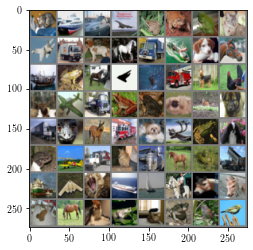

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader['test'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Run discriminator on images batch

In [76]:
# This enumerator is from the model generator test function https://github.com/samet-akcay/ganomaly/blob/master/lib/model.py line 208
for i, data in enumerate(dataloader['test'], 0):
  print(i)
  print(len(data))
  break

0
2


In [77]:
len(dataloader['test'])

235

In [83]:
import time

device = "cuda:0"
an_scores = torch.zeros(size=(len(dataloader['test'].dataset),), dtype=torch.float32, device=device)
gt_labels = torch.zeros(size=(len(dataloader['test'].dataset),), dtype=torch.long,    device=device)
latent_i  = torch.zeros(size=(len(dataloader['test'].dataset), opt.nz), dtype=torch.float32, device=device)
latent_o  = torch.zeros(size=(len(dataloader['test'].dataset), opt.nz), dtype=torch.float32, device=device)

# print("   Testing model %s." % name)
times = []
total_steps = 0
epoch_iter = 0
for i, data in enumerate(dataloader['test'], 0):
    total_steps += opt.batchsize
    epoch_iter += opt.batchsize
    time_i = time.time()
    model.set_input(data)
    fake, latent_i, latent_o = model.netg(model.input)

    error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1)
    time_o = time.time()

    an_scores[i*opt.batchsize : i*opt.batchsize+error.size(0)] = error.reshape(error.size(0))
    gt_labels[i*opt.batchsize : i*opt.batchsize+error.size(0)] = gt.reshape(error.size(0))
    latent_i [i*opt.batchsize : i*opt.batchsize+error.size(0), :] = latent_i.reshape(error.size(0), opt.nz)
    latent_o [i*opt.batchsize : i*opt.batchsize+error.size(0), :] = latent_o.reshape(error.size(0), opt.nz)

    times.append(time_o - time_i)

    # Save test images.
    if opt.save_test_images:
        dst = os.path.join(opt.outf, opt.name, 'test', 'images')
        if not os.path.isdir(dst):
            os.makedirs(dst)
        real, fake, _ = get_current_images()
        vutils.save_image(real, '%s/real_%03d.eps' % (dst, i+1), normalize=True)
        vutils.save_image(fake, '%s/fake_%03d.eps' % (dst, i+1), normalize=True)

# Measure inference time.
times = np.array(times)
times = np.mean(times[:100] * 1000)

# Scale error vector between [0, 1]
an_scores = (an_scores - torch.min(an_scores)) / (torch.max(an_scores) - torch.min(an_scores))
# auc, eer = roc(gt_labels, an_scores)
auc = evaluate(gt_labels, an_scores, metric=opt.metric)
performance = OrderedDict([('Avg Run Time (ms/batch)', times), (opt.metric, auc)])

if opt.display_id > 0 and opt.phase == 'test':
    counter_ratio = float(epoch_iter) / len(dataloader['test'].dataset)

NameError: ignored